In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils

In [5]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import json

In [6]:
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

In [7]:
def normalize(image):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0).cuda())
    return image


def predict(image):
    _, index = vgg(image).data[0].max(0)
    return str(index.item()), labels[str(index.item())][1]
    
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

In [8]:
%ls

image02.png  imagenet_class_index.json  sample_data/


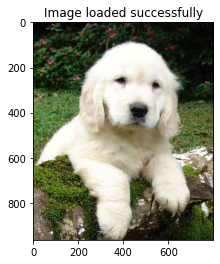

In [9]:
scene_1 = load_image("/content/image02.png")

In [10]:
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [11]:
vgg = vgg.cuda()

In [12]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
labels = json.load(open('/content/imagenet_class_index.json'))

In [14]:
# print(labels)

In [15]:
scene_2 = normalize(scene_1)
print(predict(scene_2))

('207', 'golden_retriever')


In [93]:
modulelist = list(vgg.features.modules())

# Output of various layers

In [111]:
def layer_outputs(image):
    outputs = []
    names = []
    for layer in modulelist[1:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
        
    output_im = []
    for i in outputs:
        i = i.squeeze(0)
        temp = to_grayscale(i)
        output_im.append(temp.data.cpu().numpy())
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (1200, 1500)


    for i in range(len(output_im)):
        a = fig.add_subplot(8,4,i+1)
        imgplot = plt.imshow(output_im[i])
        plt.axis('off')
        a.set_title(names[i].partition('(')[0], fontsize=30)

    plt.savefig('layer_outputs.jpg', bbox_inches='tight')

In [112]:
layer_outputs(scene_2)

# Output of each filter separately at given layer

In [113]:
def filter_outputs(image, layer_to_visualize):
    if layer_to_visualize < 0:
        layer_to_visualize += 31
    output = None
    name = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer)
    
    filters = []
    output = output.data.squeeze()
    for i in range(output.shape[0]):
        filters.append(output[i,:,:])
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (10, 10)

    for i in range(int(np.sqrt(len(filters))) * int(np.sqrt(len(filters)))):
        fig.add_subplot(np.sqrt(len(filters)), np.sqrt(len(filters)),i+1)
        imgplot = plt.imshow(filters[i].cpu())
        plt.axis('off')
    
#     print(len(filters))
#     print(filters[0].shape)
        
            
#     print(output.shape)

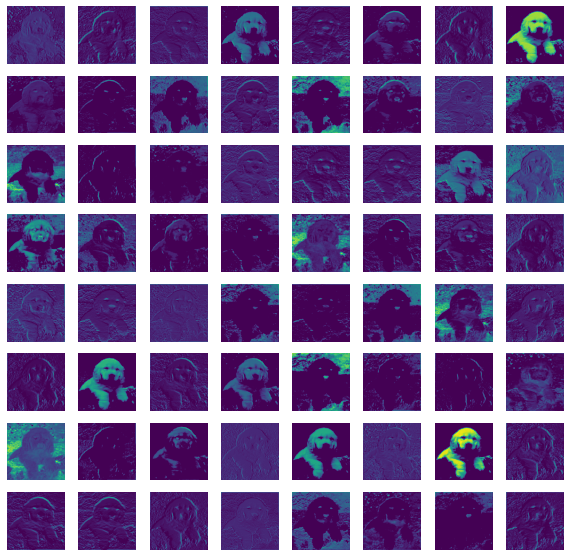

In [115]:
filter_outputs(scene_2, 0)

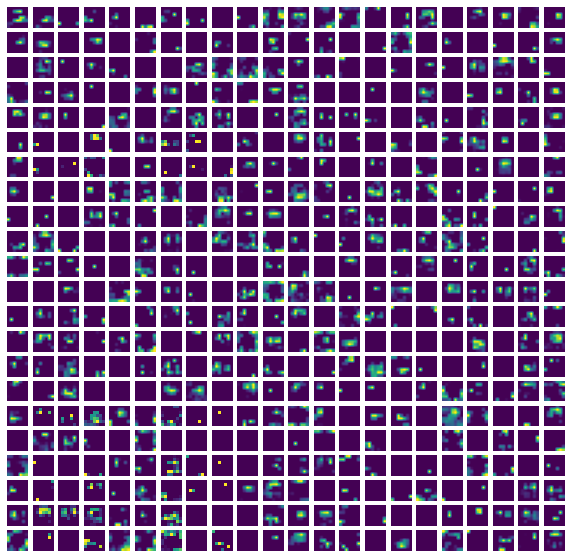

In [98]:
filter_outputs(scene_2, -1)

# Visualize weights

In [99]:
def visualize_weights(image, layer):
    weight_used = []
    for w in vgg.features.children():
        if isinstance(w, torch.nn.modules.conv.Conv2d):
            weight_used.append(w.weight.data)

    filters = []
    for i in range(weight_used[layer].shape[0]):
        filters.append(weight_used[layer][i,:,:,:].sum(dim=0))
        filters[i].div(weight_used[layer].shape[1])
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (10, 10)
    for i in range(int(np.sqrt(weight_used[layer].shape[0])) * int(np.sqrt(weight_used[layer].shape[0]))):
        a = fig.add_subplot(np.sqrt(weight_used[layer].shape[0]),np.sqrt(weight_used[layer].shape[0]),i+1)
        imgplot = plt.imshow(filters[i].cpu())
        plt.axis('off')

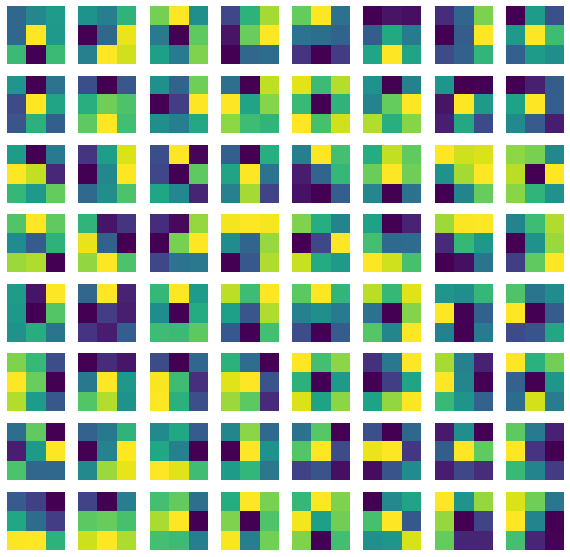

In [100]:
# First conv layer filters
visualize_weights(scene_2, 0)

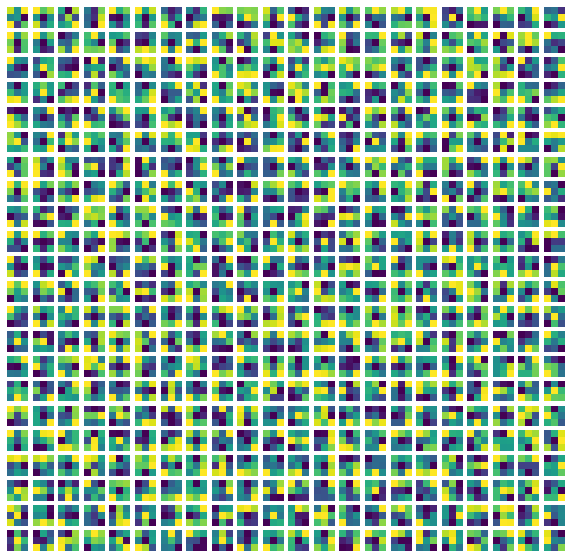

In [101]:
# Last conv layer filters
visualize_weights(scene_2, -1)